# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

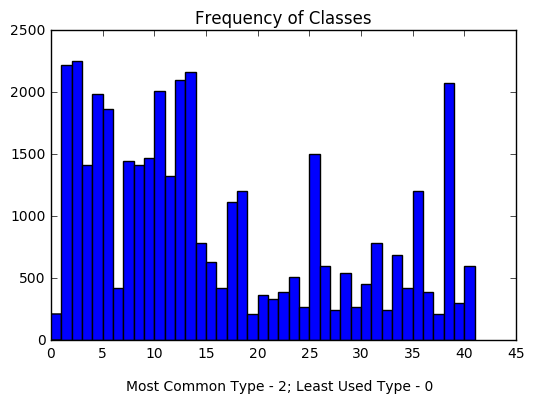

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import pylab
import random
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

# Show a random data from the input set along with its label
def show_random_data(data, labels):
    random_index = random.randint(0, len(data)-1)
    plt.imshow(data[random_index])
    plt.title("Class Label is : {} for train data #{}".format(labels[random_index], random_index+1))
    
# display an image, will be useful to view images during processing
def show_image(input, color=None):
    plt.imshow(input, cmap=color)
    plt.title("Output Image")
    
# general stats regarding data. display histogram with most frequent and lease frequent
def show_data_class_frequency(x,y):
    plt.title("Frequency of Classes")
    plt.hist(y, bins=np.arange(y.min(), y.max()))
    most_common = np.argmax(np.bincount(y))
    least_used = np.argmin(np.bincount(y))
    plt.figtext(s="Most Common Type - {}; Least Used Type - {}".format(most_common, least_used), x=0.25, y=0)

# show_image(X_train[37505,:,:,0], 'gray')
# show_random_data(X_train, y_train)
show_data_class_frequency(X_train, y_train)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import time

def normalize_data(data):
    return (data.astype(float) - 128) / 128

def rgb_to_yuv(rgb_data):
    
    yuv_data = []
    
    for i in range(0, len(rgb_data)):
        # separate all three layers
        r_plane = rgb_data[i,:,:,0]
        g_plane = rgb_data[i,:,:,1]
        b_plane = rgb_data[i,:,:,2]

        # calculate the new planes
        y_plane = (0.299 * r_plane) + (0.587 * g_plane) + (0.114 * b_plane)
        u_plane = 0.492 * (b_plane - y_plane)
        v_plane = 0.877 * (r_plane - y_plane)
        
        # add the planes and append it to a list
        yuv_data.append(np.concatenate((y_plane[:,:,None], u_plane[:,:,None], v_plane[:,:,None]), axis=2))
    
    # create a np array from the list
    return np.array(yuv_data)

def rgb_to_grayscale(rgb_data):
    
    grayscale_data = []
    
    for i in range(0, len(rgb_data)):
        # separate all three layers
        r_plane = rgb_data[i,:,:,0]
        g_plane = rgb_data[i,:,:,1]
        b_plane = rgb_data[i,:,:,2]

        # calculate the new planes
        gray_plane = (0.299 * r_plane) + (0.587 * g_plane) + (0.114 * b_plane)
        
        # add the planes and append it to a list
        grayscale_data.append(gray_plane)
    
    # create a np array from the list
    return np.array(grayscale_data).reshape(-1,32,32,1)

preprocessing_start_time = time.time()

# normalize the data
X_train_normalized = normalize_data(X_train)

# convert the data from RGB to Grayscale
X_train_gray = rgb_to_grayscale(X_train_normalized)

print("Data successfully pre-processed ...")
print("Pre-processing took {0:.2f} seconds.".format((time.time() - preprocessing_start_time)))

Data successfully pre-processed ...
Pre-processing took 2.31 seconds.


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The data was 

1. normalized with values between -1 to 1. This was done to avoid calculations of large numbers and thus improving the numerical stability.
2. converted to the RGB space. I chose this technique since colors are not important in our model. By computing this linear transormation beforehand we also save data and computing power as the model does not have to use resources to learn that colors are not relevant. Also, the accuracy detection was better with Grayscale than the YUV variant. 

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from scipy import ndimage
import math

# method to rotate the image by a certain angle. The size of the image is preserved.
def rotate_image(data, angle):
    return ndimage.rotate(data, angle, mode='reflect', reshape=False)

# method to shift the image. 
def shift_image(data, shift):
    return ndimage.shift(data, shift, mode='reflect')

# method to generate fake data from the original set
def generate_fake_data(X_original, y_original, min_count=1000):
    
    # initialize empty lists
    x = []
    y = []
    
    tbg = {}
    tbg_count = {}
    
    # loop through the original set
    for i in range(0, len(X_original)):

        # add original data
        x.append(X_original[i])
        y.append(y_original[i])
        
        actual_count = np.bincount(y_original)[y_original[i]]
        
        if(actual_count < min_count):
            
            # note the number of items to be generated for the type
            if y_original[i] not in tbg_count:
                tbg_count[y_original[i]] = min_count - actual_count
            
            if y_original[i] in tbg:
                tbg[y_original[i]].append(X_original[i])
            else:
                tbg[y_original[i]] = [X_original[i]]
                
        
    for key in tbg_count:
        
        count = 0
        
        for j in range(math.ceil(tbg_count[key]/4)):
            
            img = random.choice(tbg[key])
            count = count+1;
            
            # add image rotated by 15 degrees
            x.append(rotate_image(img, random.randint(-25, 25)))
            y.append(key)

            # add image rotated by -15 degrees
            x.append(rotate_image(img, random.randint(-25, 25)))
            y.append(key)

            # add image shifted by 2
            x.append(shift_image(img, random.randint(-5, 5)))
            y.append(key)

            # add image shifted by -1
            x.append(shift_image(img, random.randint(-5, 5)))
            y.append(key)

        print("{} images generated for type {}".format(count*4, key))
    
    return {
            "x": np.array(x).reshape(-1,32,32,1),
            "y": np.array(y),
    }


In [6]:
# generate data from existing set
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

data_gen_start_time = time.time()

# ensure there is atleast 2500 records for each type of data.
fake_data = generate_fake_data(X_train_gray, y_train, 2500)
print("Data generation took {0:.2f} minutes.".format((time.time() - data_gen_start_time)/60))

x_all = fake_data["x"]
y_all = fake_data["y"]

X_train_all, X_validation, y_train_all, y_validation = train_test_split(x_all, y_all, test_size=0.2, random_state=40)

print("More data generated successfully ... ")
print("Total train images: {}".format(len(X_train_all)))
print("Total train labels: {}".format(len(y_train_all)))
print("Total validation images: {}".format(len(X_validation)))
print("Total validation labels: {}".format(len(y_validation)))

# show_data_class_frequency(x_all, y_all)

2292 images generated for type 0
280 images generated for type 1
252 images generated for type 2
1092 images generated for type 3
520 images generated for type 4
640 images generated for type 5
2080 images generated for type 6
1060 images generated for type 7
1092 images generated for type 8
1032 images generated for type 9
492 images generated for type 10
1180 images generated for type 11
400 images generated for type 12
340 images generated for type 13
1720 images generated for type 14
1872 images generated for type 15
2080 images generated for type 16
1392 images generated for type 17
1300 images generated for type 18
2292 images generated for type 19
2140 images generated for type 20
2172 images generated for type 21
2112 images generated for type 22
1992 images generated for type 23
2232 images generated for type 24
1000 images generated for type 25
1900 images generated for type 26
2260 images generated for type 27
1960 images generated for type 28
2232 images generated for type 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I split the data into two in a ratio of 80:20. 80% served as the training data while 20% served as the testing data. Each list contains random data from the original list.

Also before I split the data, I generated fake data as the frequency distribution of the original data clearly was not uniform. Some types of data had a frequency of more than 2000, while some had less than 500. So I made sure each types had atleast 2500 data in it. Data was randomly generated by rotating and shifting the original data between -25 to 25 degrees or by -5 to 5 units of shift. 

The final list was then split into two for training and validation as described above.


In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def net(x, weights, biases):
    
    # first convolution layer, input = 32x32x3, output = 28x28x6. Stride of 1
    layer_1_conv = tf.nn.conv2d(x, weights["layer_1"], [1,1,1,1], 'VALID')
    layer_1_conv = tf.nn.bias_add(layer_1_conv, biases["layer_1"])
    
    # activation for first layer
    layer_1_activation = tf.nn.tanh(layer_1_conv)
    
    # max pool for the first layer as a subsampling technique, input = 28x28x6, output = 14x14x6
    pooling_1 = tf.nn.max_pool(layer_1_activation, [1,2,2,1], [1,2,2,1], 'VALID')
    
    # second convolution layer, input = 14x14x6, output = 10x10x36. Stride of 1
    layer_2_conv = tf.nn.conv2d(pooling_1, weights["layer_2"], [1,1,1,1], 'VALID')
    layer_2_conv = tf.nn.bias_add(layer_2_conv, biases["layer_2"])
    
    # activation for second layer
    layer_2_activation = tf.nn.tanh(layer_2_conv)
    
    # max pool for the second layer as a subsampling technique, input = 10x10x36, output = 5x5x36
    pooling_2 = tf.nn.max_pool(layer_2_activation, [1,2,2,1], [1,2,2,1], 'VALID')
    
    # flatten the data, output = 1x900
    flat_data = flatten(pooling_2)
    
    # fully connected layer, output = 1x240
    layer_3_fc = tf.add(tf.matmul(flat_data, weights["layer_3"]), biases["layer_3"])
    
    # activation for third layer
    layer_3_activation = tf.nn.tanh(layer_3_fc)
    
    # fully connected layer, output = 1x120
    layer_4_fc = tf.add(tf.matmul(layer_3_activation, weights["layer_4"]), biases["layer_4"])
    
    # activation for fourth layer
    layer_4_activation = tf.nn.tanh(layer_4_fc)
    
    # fully connected layer, output = 1x43
    layer_5_fc = tf.add(tf.matmul(layer_4_activation, weights["layer_5"]), biases["layer_5"])
    
    return layer_5_fc
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The neural architecture has 2 levels of convolution layers followed by three layers of Fully Connected Layers similar to the LeNet architecture. All layers are activated by a tanh function. The convolution layers use a stride of 1 with Valid padding and pass through a max pool sampling at the end of the convolution. The output of the final FC layer is a 43 element data and the loss is calculated agains the one hot encode output with the cross entropy function.

In [46]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [47]:
# setup hyperparameters

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
REG_CONSTANT = 0.01

In [48]:
# setup variables

x = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y,43)

weights = {
    "layer_1": tf.Variable(tf.truncated_normal([5,5,1,6])), # use stride 1 to get 28x28x6
    "layer_2": tf.Variable(tf.truncated_normal([5,5,6,36])), # on an image of 14x14x6 to get 10x10x36, stride 1
    "layer_3": tf.Variable(tf.truncated_normal([900,480])), # 900 input to a fully connected layer
    "layer_4": tf.Variable(tf.truncated_normal([480,240])), # 480 input to a fully connected layer
    "layer_5": tf.Variable(tf.truncated_normal([240,43])) # 240 input to a fully connected layer
}
    
biases = {
    "layer_1": tf.Variable(tf.zeros([6])), 
    "layer_2": tf.Variable(tf.zeros([36])), 
    "layer_3": tf.Variable(tf.zeros([480])),
    "layer_4": tf.Variable(tf.zeros([240])),
    "layer_5": tf.Variable(tf.zeros([43]))
}


In [49]:
# setup optimizer and cost functions

logits = net(x, weights, biases)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
probabilities = tf.nn.softmax(logits)

# add regularization to the loss
loss_operation = tf.reduce_mean(cross_entropy 
                                + REG_CONSTANT*tf.nn.l2_loss(weights["layer_1"]) 
                                + REG_CONSTANT*tf.nn.l2_loss(weights["layer_2"]) 
                                + REG_CONSTANT*tf.nn.l2_loss(weights["layer_3"]) 
                                + REG_CONSTANT*tf.nn.l2_loss(weights["layer_4"])
                                + REG_CONSTANT*tf.nn.l2_loss(weights["layer_4"])
                               )

# use Adam optimizer for faster and improved gradient
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [50]:
# define validation methods here

correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# evaluate the accuracy of the model
def evaluate(x_data, y_data):
    total_batches = math.ceil(len(x_data) / BATCH_SIZE)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for j in range(total_batches):
        start = j * BATCH_SIZE
        end = start + BATCH_SIZE
        x_batch = x_data[start:end]
        y_batch = y_data[start:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: x_batch, y: y_batch})
        total_accuracy = total_accuracy + (accuracy * len(x_batch))
        
    return total_accuracy / len(x_data)


In [51]:
import math

def train(X_train_all, y_train_all, X_validation, y_validation):
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # for each epoch train the model
        for i in range(EPOCHS):
            epoch_start_time = time.time()
            
            X_train_all, y_train_all = shuffle(X_train_all, y_train_all)
            total_batches = math.ceil(len(X_train_all) / BATCH_SIZE)
            
            # split the data into batches
            for j in range(total_batches):
                
                start = j * BATCH_SIZE
                end = start + BATCH_SIZE
                
                x_batch = X_train_all[start:end]
                y_batch = y_train_all[start:end]
                
                # train the model
                sess.run(training_operation, feed_dict={x: x_batch, y: y_batch})
                
            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print("Epoch took {0:.2f} seconds.".format((time.time() - epoch_start_time)))
            print()
        
        saver.save(sess, 'net')
        print("Model saved")
  
print("training ...")
train(X_train_all, y_train_all, X_validation, y_validation)

training ...
EPOCH 1 ...
Validation Accuracy = 0.038
Epoch took 7.56 seconds.

EPOCH 2 ...
Validation Accuracy = 0.041
Epoch took 7.52 seconds.

EPOCH 3 ...
Validation Accuracy = 0.051
Epoch took 7.53 seconds.

EPOCH 4 ...
Validation Accuracy = 0.055
Epoch took 7.51 seconds.

EPOCH 5 ...
Validation Accuracy = 0.054
Epoch took 7.51 seconds.

EPOCH 6 ...
Validation Accuracy = 0.058
Epoch took 7.51 seconds.

EPOCH 7 ...
Validation Accuracy = 0.059
Epoch took 7.50 seconds.

EPOCH 8 ...
Validation Accuracy = 0.061
Epoch took 7.51 seconds.

EPOCH 9 ...
Validation Accuracy = 0.065
Epoch took 7.52 seconds.

EPOCH 10 ...
Validation Accuracy = 0.061
Epoch took 7.51 seconds.

EPOCH 11 ...
Validation Accuracy = 0.068
Epoch took 7.51 seconds.

EPOCH 12 ...
Validation Accuracy = 0.071
Epoch took 7.52 seconds.

EPOCH 13 ...
Validation Accuracy = 0.074
Epoch took 7.52 seconds.

EPOCH 14 ...
Validation Accuracy = 0.079
Epoch took 7.51 seconds.

EPOCH 15 ...
Validation Accuracy = 0.087
Epoch took 7.51 s

In [52]:
def test_accuracy(inputs, labels):

    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        test_accuracy = evaluate(inputs, labels)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

In [53]:
test_data_normalized = normalize_data(X_test)
test_data_gray = rgb_to_grayscale(test_data_normalized)
test_accuracy(test_data_gray, y_test)

Test Accuracy = 0.924


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I trained the model using an Adam optimizer that fed the data through two layers of convolutions and then to three fully connected layers. Both the convolution layers and the outer layers were activated by tanh activations. I used tanh as we are calculating probabilities and not actual numbers. Tanh actications throughout gave me better performance than a combination of ReLu for convolution layers and tanh for fully connected layers.

The network also adds L2 norm of the weights to the loss in order to penalize higher valued weights and thus prevented over fitting. The network uses max pooling to sub-sample the layers. The fully connected layers are regular logistic classifiers and the loss is calculated by cross entropy between the logits and one hot encoded labels.

I used a batch size of 128 for 100 epochs with a learning rate of 0.0001 and a regularization constant of 0.01 to acheived an overall training accuracy of 97.1%

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Pre-processing:

Initially I tried converting the RGB data to a YUV space. But while experimenting I realised the model really does not need the UV data. So I changed the preprocessing technique to Grayscale from RGB. This gave me better validation accuracy. Also some of the types had very low frequency of data. Hence I generated random data from the original set of images. The orginal images were selected randomly to generate the fake data for each type.

1. The initial architecture had a convolution output of 5x5x16. The validation accuracy failed to improve after 95% and hence I added more parameters to the model and made the final output to 5x5x32

2. I started with a learning rate of 0.001. This learning rate caused the validation accuracy to juggle between 97.1 to 97.8 and dropped to 97.1% at the end of the 50 epoch cycle. 

3. I tried increasing the learning rate to 0.0001 with a batch size of 512. Also I changed the epochs to 100 and the activation functions to ReLu for the convolution layer as I thought the tanh was causing the gradient to vanish. This gave me an accuracy percentage of 96.5% which was lesser than the tanh with 50 epochs.

4. I then switched the activation functions to tanh and changed the batch size to 128. This gave me a validation accuracy of 97.7%, the highest ever.

5. This particular model only gave me an output of 32% when I validated the test data.

6. I realised my fake generation routine was at fault. I had used an algorithm that generated multiple variants (rotated and shifted) of the same image for a particular type. I changed this algorithm to randomly select an image of the desired type for each iteration and generate fake images.

7. I tried the model again, this time with a learning rate of 0.00025 for 100 epochs and a batch size of 128. This gave me an accuracy of 97.1% for the validation data and ann accuracy of 92.4% for the test data.





---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

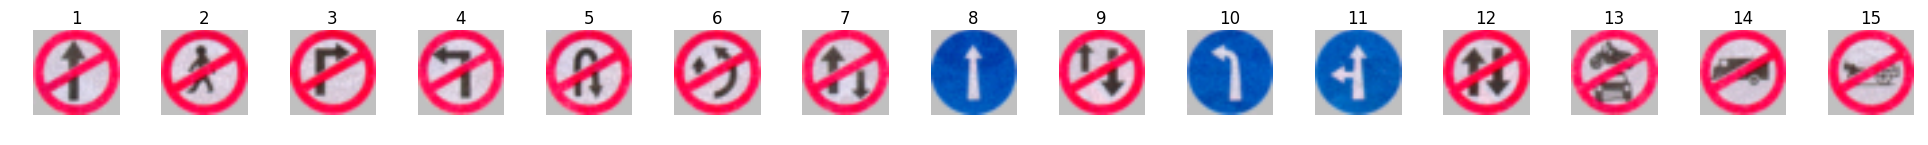

In [54]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from PIL import Image
import scipy.misc
from scipy import ndimage

# method to load image and convert to our required dimensions
def load_image(fName):
    img = scipy.misc.imread(fName)
    return scipy.misc.imresize(img[:,:,0:3],(32,32,3))

# method to plot the images on the plot
def plot_images(images):
    
    for i in range(len(images)):
        plt.figure(1,figsize=(20, 10))  
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(i+1)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.99, bottom=0.01, left=0.05,
                            right=0.99)
    plt.show()

X_local = []

X_local.append(load_image("traffic/m1.gif"))
X_local.append(load_image("traffic/m11.gif"))
X_local.append(load_image("traffic/m12.gif"))
X_local.append(load_image("traffic/m13.gif"))
X_local.append(load_image("traffic/m14.gif"))
X_local.append(load_image("traffic/m15.gif"))
X_local.append(load_image("traffic/m2.gif"))
X_local.append(load_image("traffic/m27.gif"))
X_local.append(load_image("traffic/m3.gif"))
X_local.append(load_image("traffic/m32.gif"))
X_local.append(load_image("traffic/m33.gif"))
X_local.append(load_image("traffic/m4.gif"))
X_local.append(load_image("traffic/m5.gif"))
X_local.append(load_image("traffic/m6.gif"))
X_local.append(load_image("traffic/m7.gif"))

plot_images(X_local)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

From the above set of images I chose 1, 8, 11, 13, 15. 1,8 and 8,10 are similar and should be confusing. The 13 and 15 are Indian local traffic signs. 

Expecations: 13 and 15 should not be detected. 1,8 and 11 can possibly be detected.

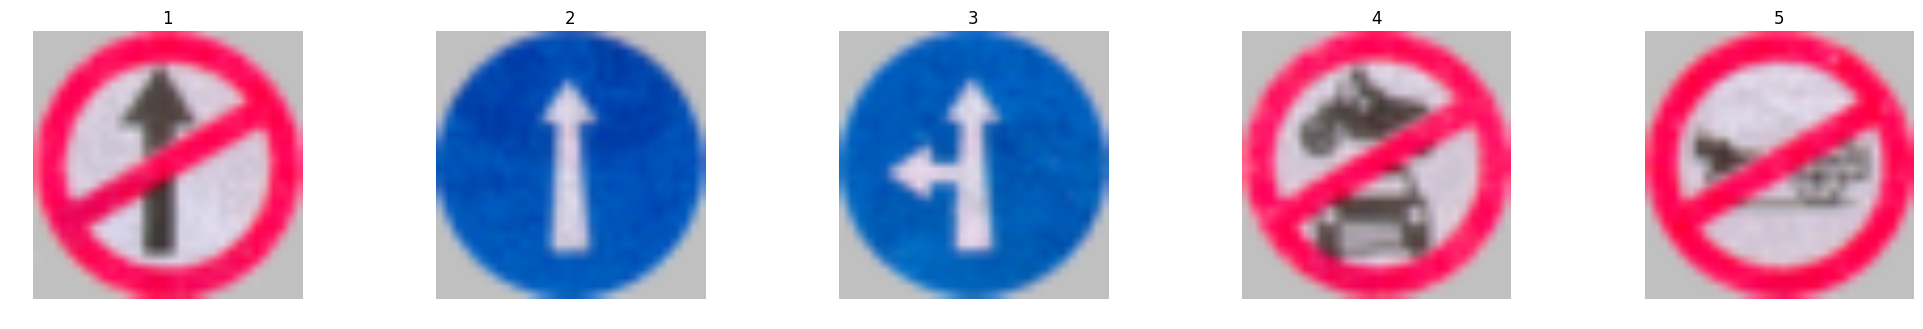

[[  1.39706384e-03   6.34782191e-04   2.30162826e-07   8.73217323e-06
    2.96844593e-08   1.41149703e-09   3.76928729e-05   7.33076447e-12
    3.09718390e-10   1.42680608e-06   2.54317789e-10   1.86402940e-05
    1.10653683e-03   1.38174668e-01   3.07986652e-03   3.25348519e-04
    4.95983663e-08   1.49569230e-03   3.95315419e-06   1.50257461e-06
    4.10283428e-05   8.53155655e-07   3.19294371e-02   3.60781632e-05
    1.85947720e-05   2.66335293e-04   4.29571280e-03   1.47504181e-06
    8.19623237e-05   2.92740260e-05   3.64140305e-06   2.98629277e-09
    6.27560681e-03   1.66429731e-03   8.32913269e-04   3.95932943e-02
    1.10467434e-01   2.92491615e-02   5.91871262e-01   7.98395090e-03
    5.94614306e-04   2.84675043e-02   9.33774027e-06]
 [  2.85901013e-04   7.83474476e-04   2.59642311e-05   1.11782319e-05
    2.66624411e-04   1.80349125e-05   9.89605269e-07   1.23989257e-05
    1.54601503e-06   1.53107308e-07   5.38853939e-09   2.50704680e-02
    9.44890530e-07   1.33468874e-03 

In [73]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

def test_local(local_data):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        local_logits = sess.run(probabilities, feed_dict={x:local_data})
        return local_logits
    
X_local_candidates = []
X_local_candidates.append(load_image("traffic/m1.gif"))
X_local_candidates.append(load_image("traffic/m27.gif"))
X_local_candidates.append(load_image("traffic/m33.gif"))
X_local_candidates.append(load_image("traffic/m5.gif"))
X_local_candidates.append(load_image("traffic/m7.gif"))

plot_images(X_local_candidates)
        
local_data_normalized = normalize_data(np.array(X_local_candidates))
local_data_gray = rgb_to_grayscale(local_data_normalized)
local_logits = test_local(local_data_gray)

print(local_logits)

# manually determine actual labels. All the images are specific to Indian traffic.
# The fifth image means no Bullock Cart and the closest alternative in the labels is 15 which is no vehicles
# Image 1 - No Entry - 17
# Image 2 - Only Straight - 35
# Image 3 - Straight or Left - 37
# Image 4 - No Vehicles - 15
# Image 5 - No Bullock Carts - 15 (No Vehicles, closest)

y_local_candidates = [17, 35, 37, 15, 15]

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

No it did not perform as expected. This is because most of the captured images very specific to a different region from the training data set. I got an accuracy of 20% and two of the data had the labels in the top 5 predictions.

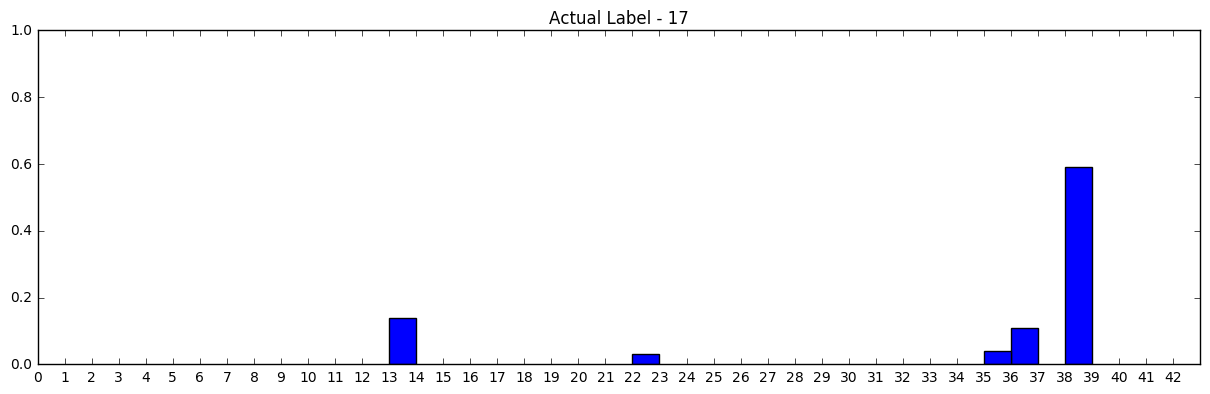

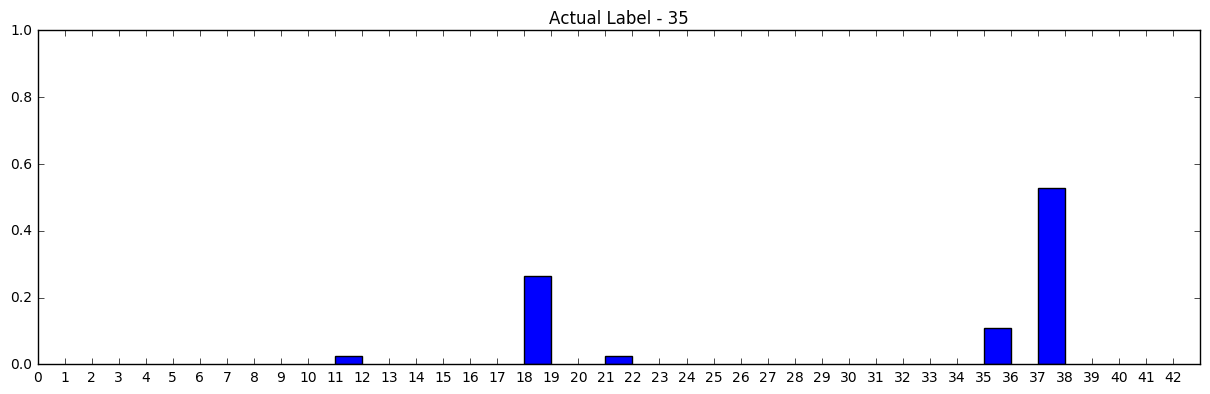

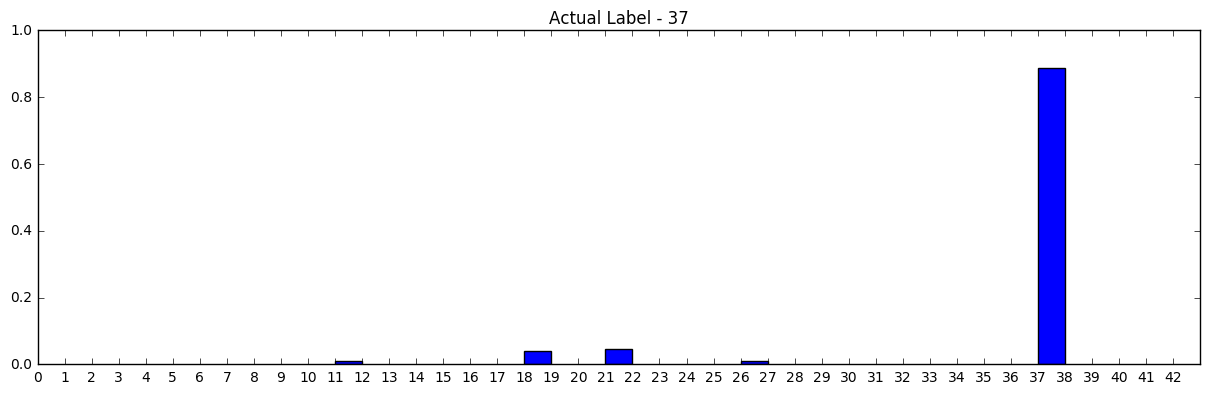

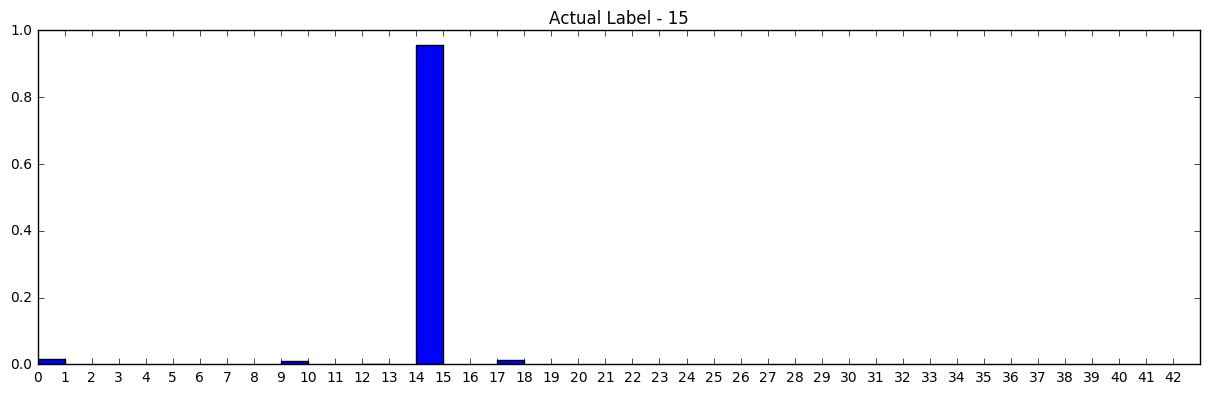

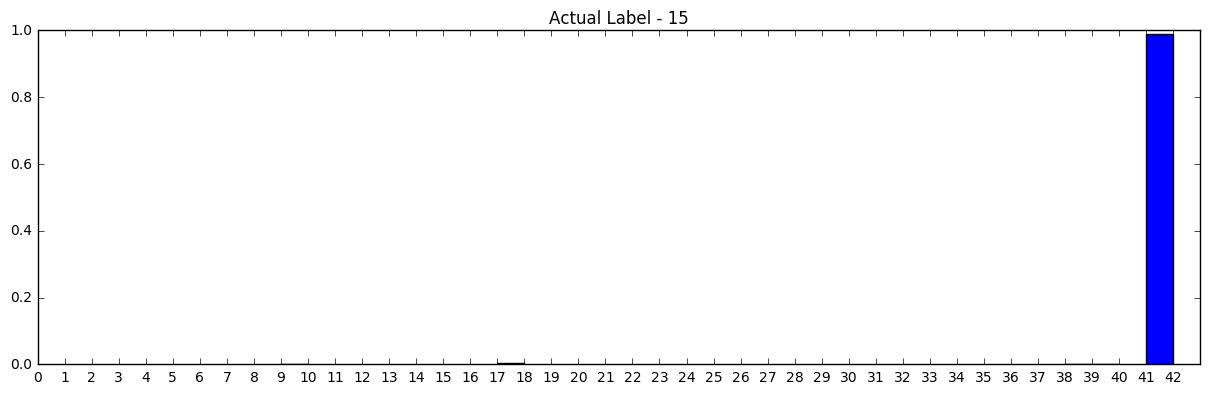

In [75]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def get_top_predictions(inputs, size):
    with tf.Session() as sess:
        top_predictions = sess.run(tf.nn.top_k(tf.constant(inputs), k=size))
        return top_predictions

predictions = get_top_predictions(local_logits,5)

labels = predictions.indices
scores = predictions.values

for i in range(0, len(labels)) :
    plt.figure(1,figsize=(15,25))
    plt.subplot(len(labels), 1, i+1)
    plt.bar([labels[i][0],labels[i][1],labels[i][2],labels[i][3],labels[i][4]], 
            [scores[i][0],scores[i][1],scores[i][2],scores[i][3],scores[i][4]], 1)
    plt.axis([0, 43, 0, 1])
    plt.xticks(np.arange(0, 43, 1.0))
    plt.title(s="Actual Label - " + str(y_local_candidates[i]))
    plt.show()  


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

One data had the correct predictions in the top 5. One other data was detected accurately. All other data had a related sign (Go Straight instead of No Straight) in the label but the exact label was not in the top 5 predictions. 

Image #3 had the correct prediction.
Image #2 had the correct prediction as the third candidate.
Image #1 had related labels in the predictions. (viz, signs related to straights)
Image #4 was detected as a Stop sign instead of a No Vehicles sign
Image #5 was completely wrong

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.